In [1]:
import pandas as pd
import numpy as np
import seaborn as sns                    
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [2]:
# read data
df = pd.read_pickle('df.pkl') 
iqr = df['PAID_AMOUNT'].quantile(0.75) - df['PAID_AMOUNT'].quantile(0.25)
upper_border = df['PAID_AMOUNT'].quantile(0.75) + iqr*1.5

# Explore data distribution for PAID_AMOUNT

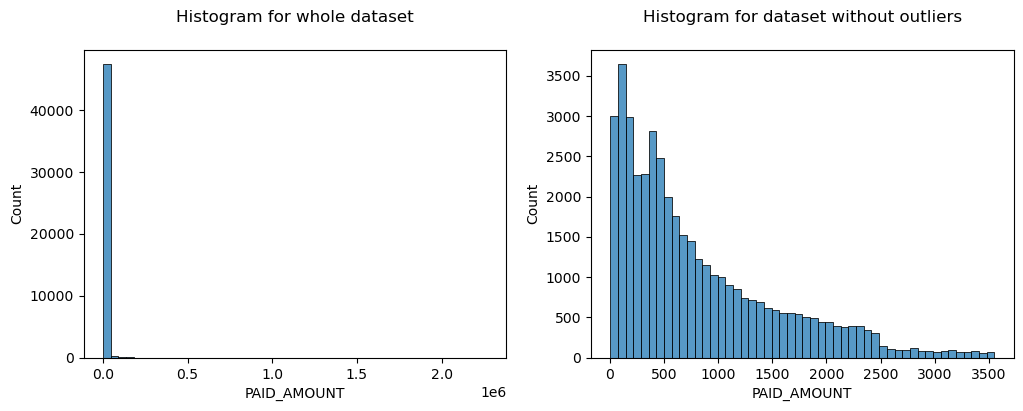

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df['PAID_AMOUNT'], bins = 50, ax = ax1)
sns.histplot(df[df['PAID_AMOUNT'] <= upper_border]['PAID_AMOUNT'], bins = 50, ax = ax2)
ax1.set_title('Histogram for whole dataset', pad=20)
ax2.set_title('Histogram for dataset without outliers', pad=20)
plt.show()

### Summary: data is rigth skewed

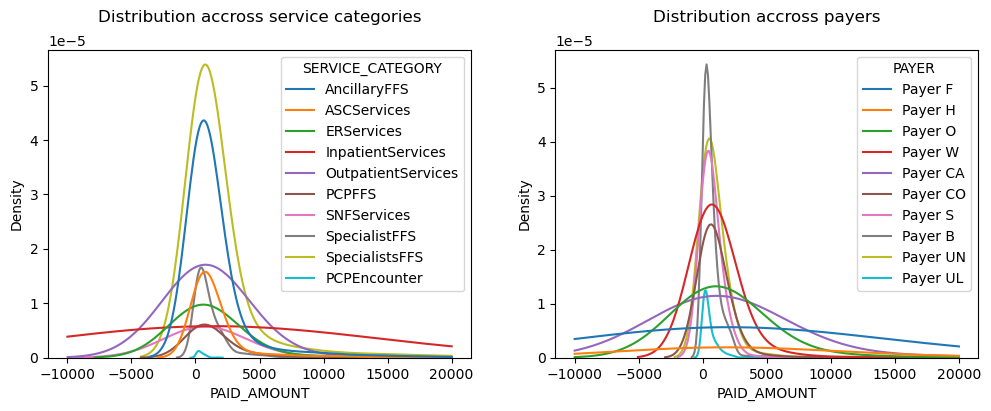

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.kdeplot(df,
            x = 'PAID_AMOUNT',
           hue = 'SERVICE_CATEGORY',
           clip=(-10000, 20000), ax = ax1)
sns.kdeplot(df,
            x = 'PAID_AMOUNT',
           hue = 'PAYER',
           clip=(-10000, 20000), ax = ax2)
ax1.set_title('Distribution accross service categories', pad=20)
ax2.set_title('Distribution accross payers', pad=20)
plt.show()

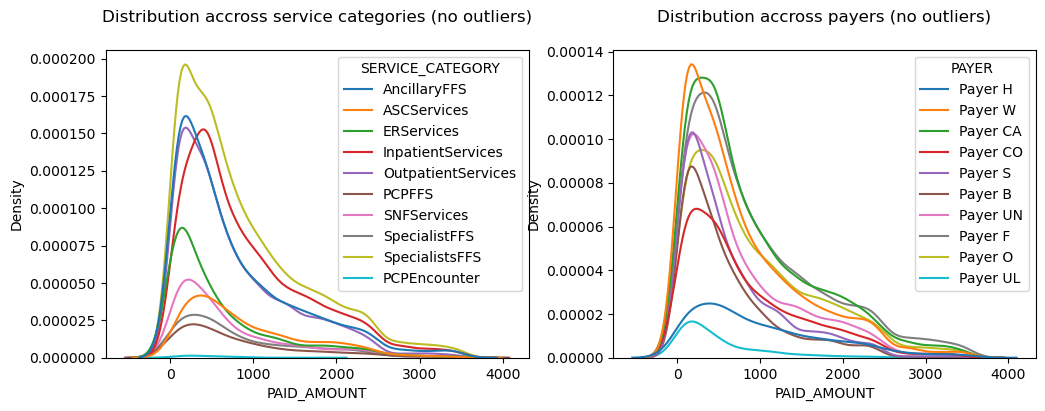

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.kdeplot(df[df['PAID_AMOUNT'] <= upper_border],
            x = 'PAID_AMOUNT',
           hue = 'SERVICE_CATEGORY',
           clip=(-10000, 20000), ax = ax1)
sns.kdeplot(df[df['PAID_AMOUNT'] <= upper_border],
            x = 'PAID_AMOUNT',
           hue = 'PAYER',
           clip=(-10000, 20000), ax = ax2)
ax1.set_title('Distribution accross service categories (no outliers)', pad=20)
ax2.set_title('Distribution accross payers (no outliers)', pad=20)
plt.show()

## Check for trends

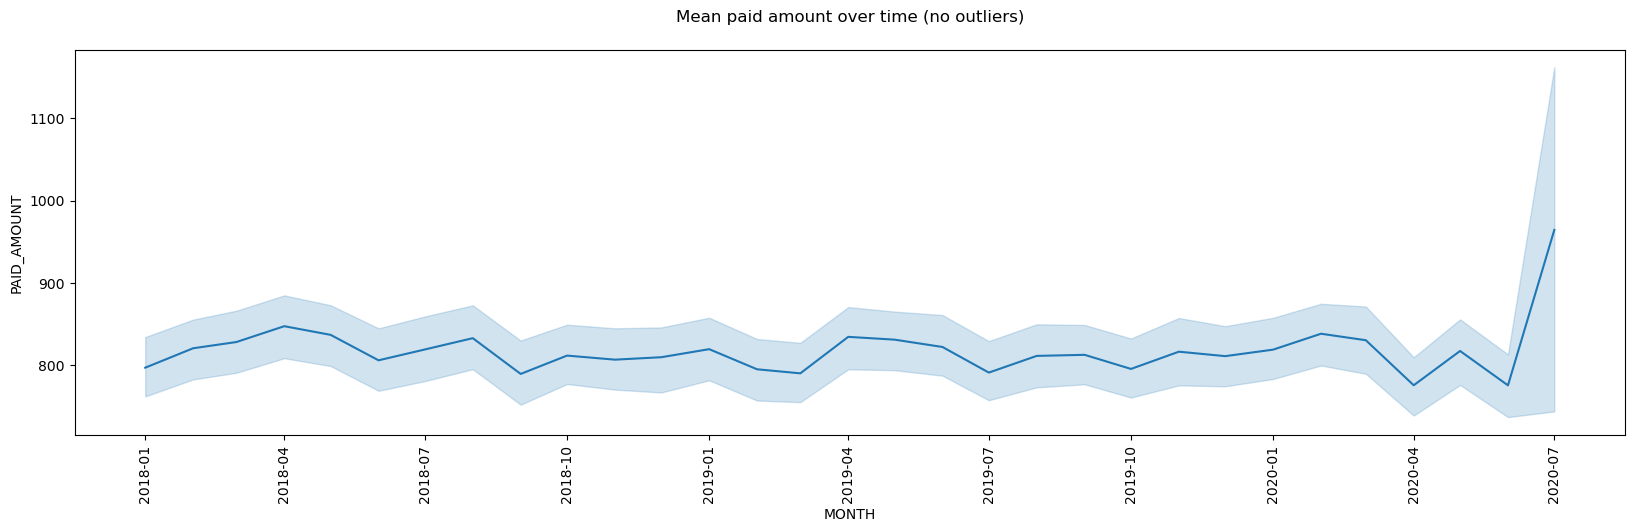

In [7]:
plt.figure(figsize=(20, 5))
sns.lineplot(data = df[df['PAID_AMOUNT'] <= upper_border],
             x = 'MONTH',
             y = 'PAID_AMOUNT')
plt.xticks(rotation=90)
plt.title('Mean paid amount over time (no outliers)', pad=20)
plt.show()

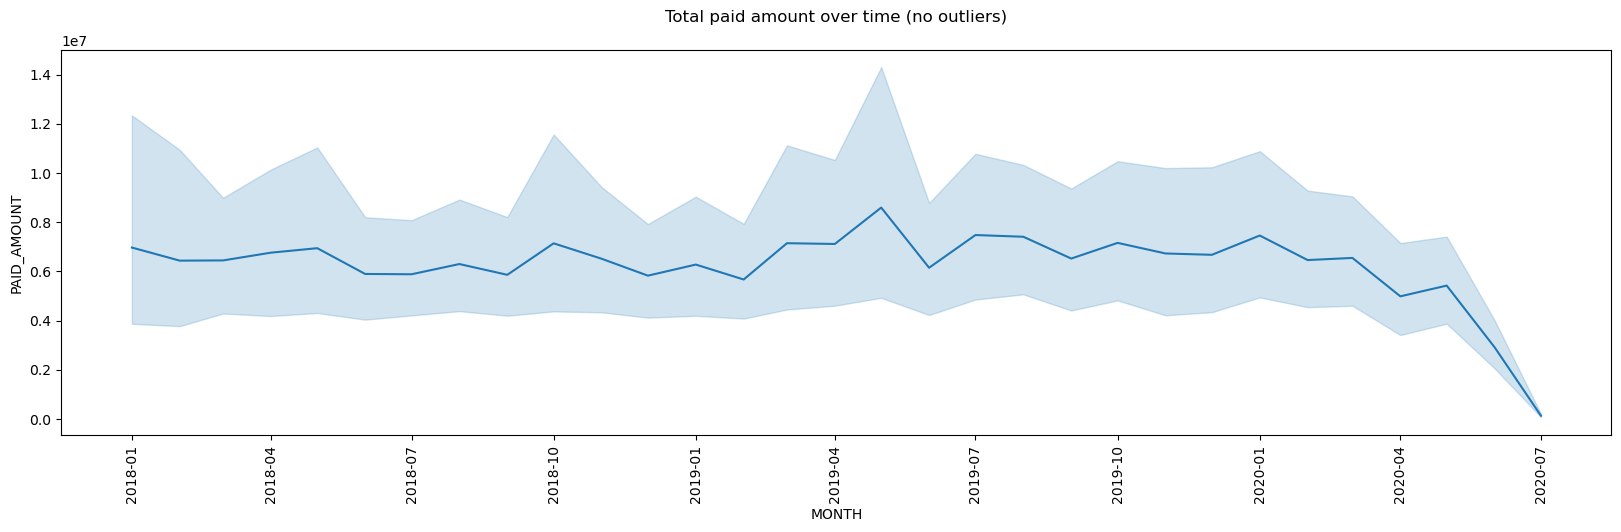

In [8]:
plt.figure(figsize=(20, 5))
sns.lineplot(data = df,
             x = 'MONTH',
             y = 'PAID_AMOUNT',
             estimator = np.sum)
plt.xticks(rotation=90)
plt.title('Total paid amount over time (no outliers)', pad=20)
plt.show()

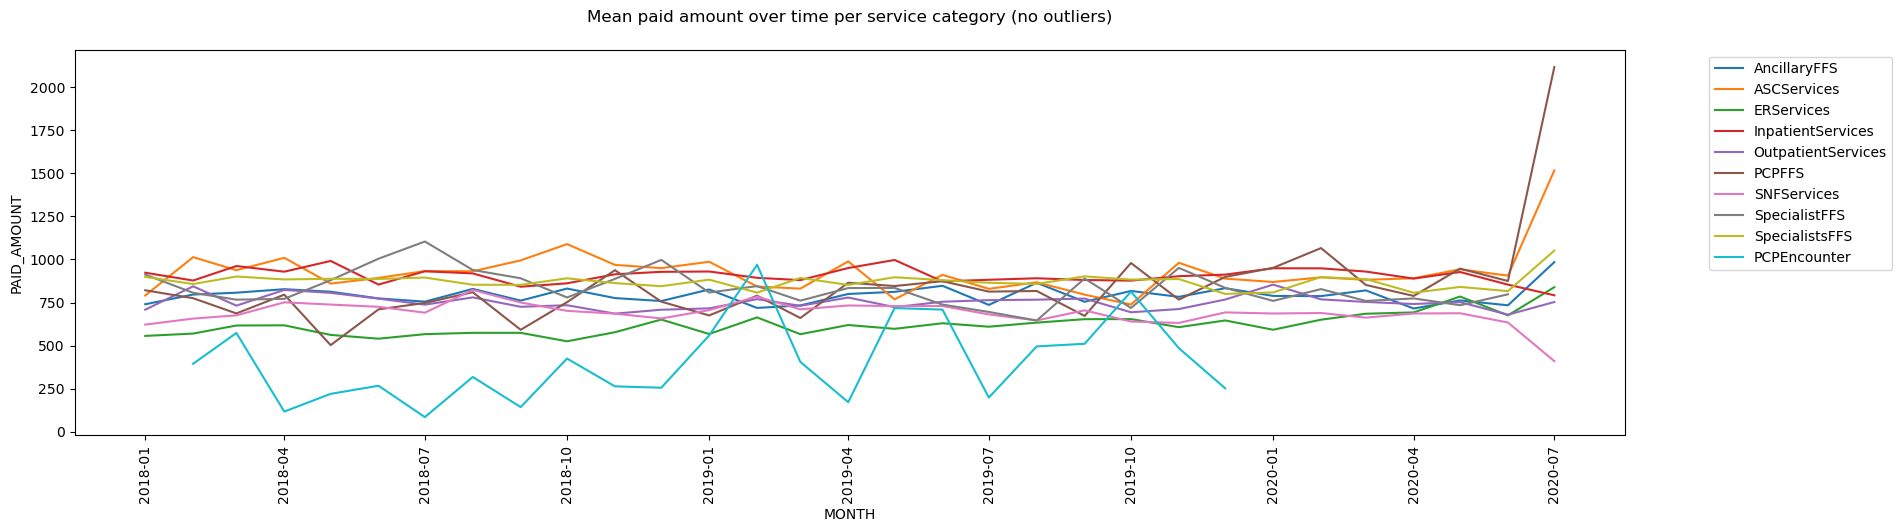

In [9]:
plt.figure(figsize=(20, 5))
sns.lineplot(data = df[df['PAID_AMOUNT'] <= upper_border],
             x = 'MONTH',
             y = 'PAID_AMOUNT',
             hue = 'SERVICE_CATEGORY',
             errorbar=None)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Mean paid amount over time per service category (no outliers)', pad=20)
plt.show()

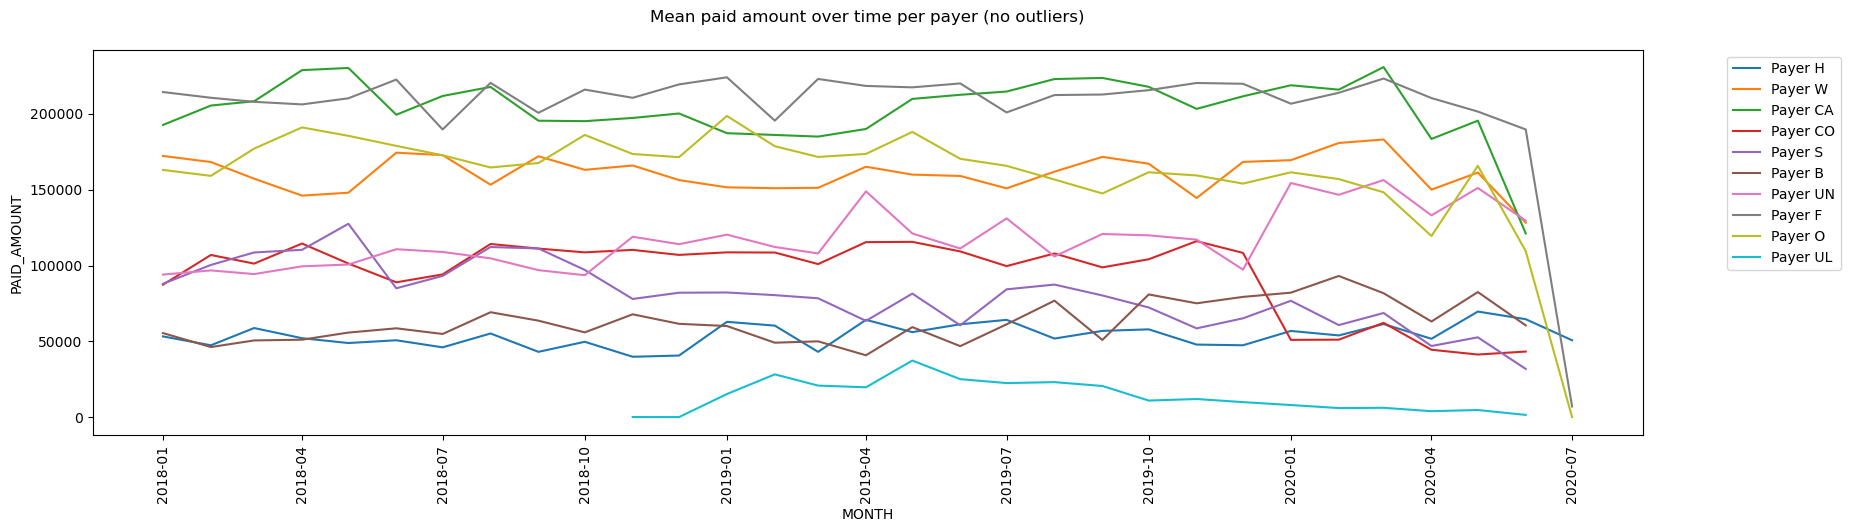

In [10]:
plt.figure(figsize=(20, 5))
sns.lineplot(data = df[df['PAID_AMOUNT'] <= upper_border],
             x = 'MONTH',
             y = 'PAID_AMOUNT',
             hue = 'PAYER',
             errorbar=None,
             estimator = np.sum)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Mean paid amount over time per payer (no outliers)', pad=20)
plt.show()

# Forecasting

In [12]:
# create time series (no outliers)
ts = df[df['PAID_AMOUNT'] <= upper_border].groupby('MONTH')[['PAID_AMOUNT']].sum()
ts['Time'] = np.arange(len(ts))

In [13]:
# Train linear regression model and predict to next 6 months
X_train = ts[['Time']]
y_train = ts['PAID_AMOUNT']

# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

future_time = pd.DataFrame({'Time': np.arange(len(ts), len(ts) + 6)}) # Next 6 months

predictions = model.predict(future_time)

In [14]:
future_dates = pd.date_range(start=ts.index[-1] + pd.DateOffset(months=1), periods=6, freq='ME')
future_ts = pd.DataFrame(predictions, index=future_dates, columns=['Predicted PAID_AMOUNT'])
future_ts.index.name = 'MONTH'
# Combine historical and future data
combined_ts = pd.concat([ts, future_ts])

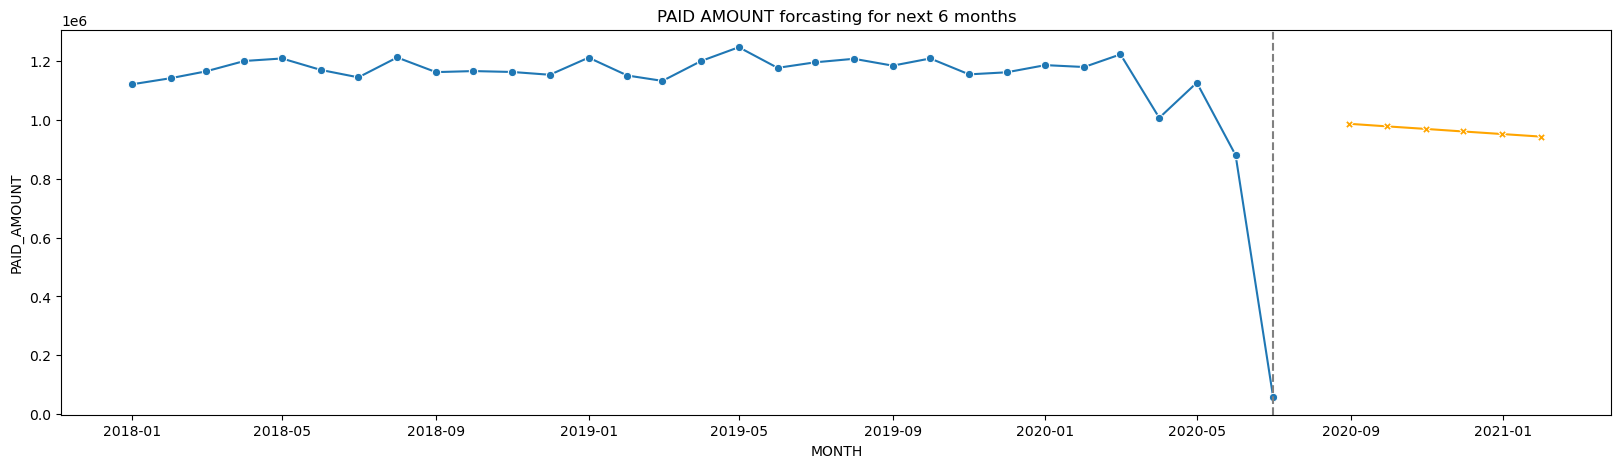

In [15]:
plt.figure(figsize=(20, 5))
sns.lineplot(data = ts,
             x = 'MONTH',
             y = 'PAID_AMOUNT',
             marker='o'
            )
sns.lineplot(data = future_ts,
             x = 'MONTH',
             y = 'Predicted PAID_AMOUNT',
             marker='X',
            color='orange')
plt.title('PAID AMOUNT forcasting for next 6 months')
plt.xlabel('MONTH')
plt.ylabel('PAID_AMOUNT')
plt.axvline(x=ts.index[-1], color='gray', linestyle='--', label='Projection Start')
plt.show()

# Forecasting per SERVICE CATEGORY

In [17]:
df_sc = df[df['PAID_AMOUNT'] <= upper_border].groupby(['MONTH','SERVICE_CATEGORY'])[['PAID_AMOUNT']].sum()
df_sc['Time'] = np.arange(len(df_sc))
df_sc = df_sc.reset_index().sort_values(by='MONTH')

In [18]:
future_time = pd.DataFrame({'Time': np.arange(len(ts), len(ts) + 6)}) # Next 6 months
future_dates = pd.date_range(start=ts.index[-1] + pd.DateOffset(months=1), periods=6, freq='ME')
combined_df_sc = df_sc.copy()
for i in df_sc['SERVICE_CATEGORY'].unique():
    X_train = df_sc[df_sc['SERVICE_CATEGORY'] == i][['Time']]
    y_train = df_sc[df_sc['SERVICE_CATEGORY'] == i][['PAID_AMOUNT']]
    
    # Train linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(future_time)

    future_df_sc = pd.DataFrame(predictions, index=future_dates, columns=['Predicted PAID_AMOUNT']) 
    future_df_sc['SERVICE_CATEGORY'] = i
    future_df_sc.index.name = 'MONTH'
    future_df_sc.reset_index(inplace=True)
    combined_df_sc = pd.concat([combined_df_sc, future_df_sc])
combined_df_sc.reset_index(drop=True, inplace=True)

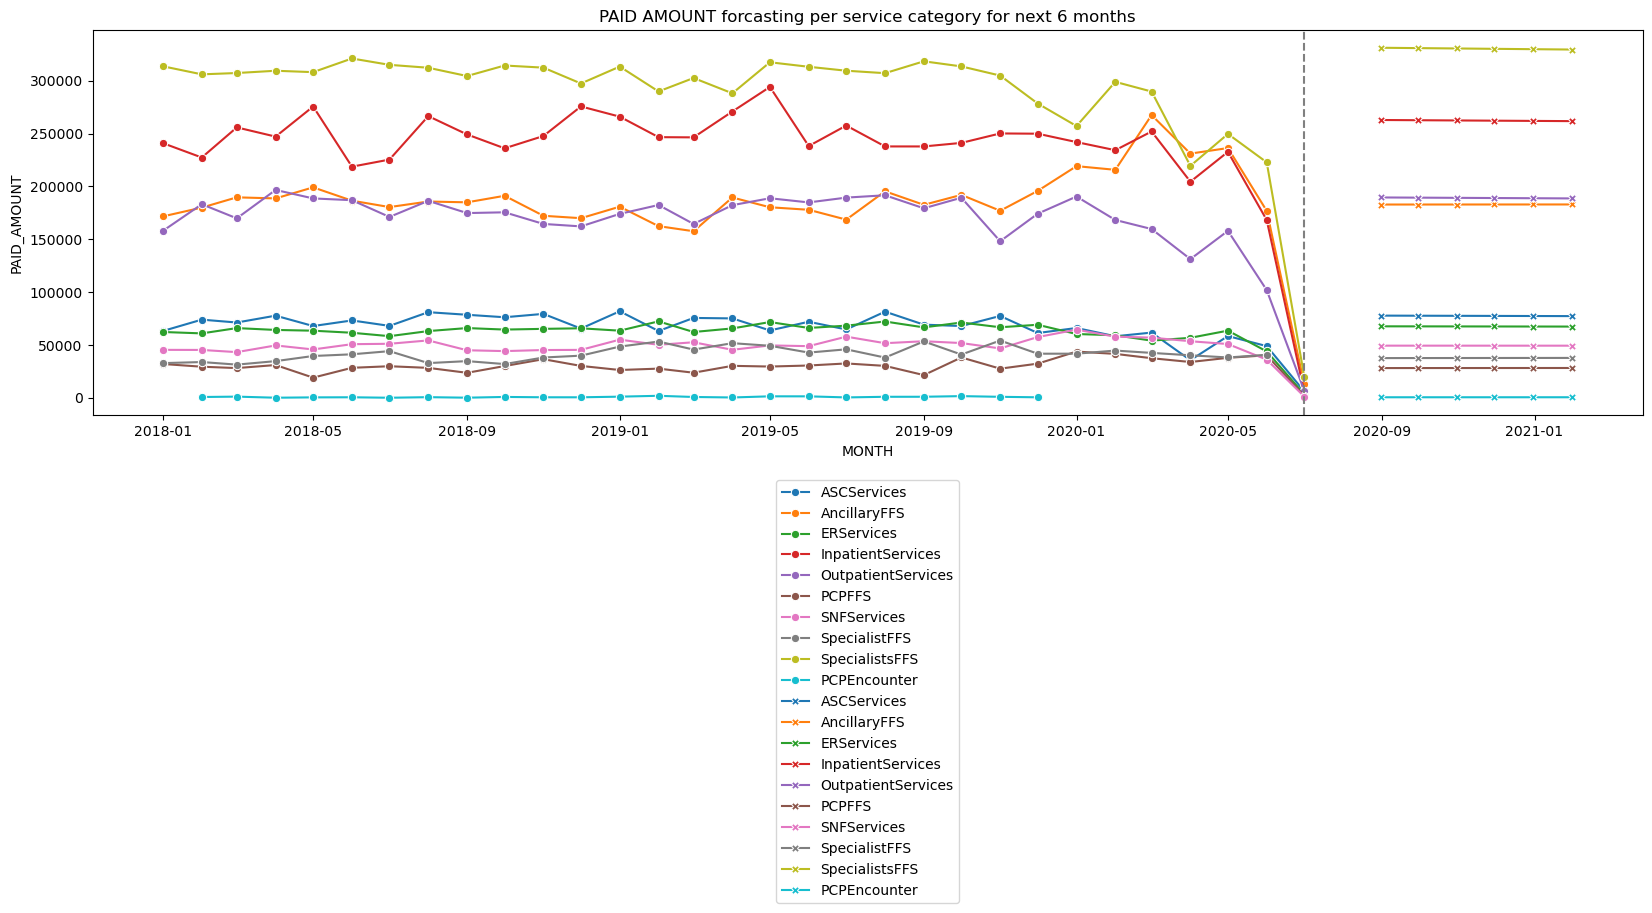

In [37]:
plt.figure(figsize=(20, 5))
sns.lineplot(data = df_sc,
             x = 'MONTH',
             y = 'PAID_AMOUNT',
             hue = 'SERVICE_CATEGORY',
             marker='o'
            )
sns.lineplot(data = combined_df_sc,
             x = 'MONTH',
             y = 'Predicted PAID_AMOUNT',
             hue = 'SERVICE_CATEGORY',
             marker='X')
plt.title('PAID AMOUNT forcasting per service category for next 6 months')
plt.xlabel('MONTH')
plt.ylabel('PAID_AMOUNT')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15))
plt.axvline(x=df_sc['MONTH'].iloc[-1], color='gray', linestyle='--', label='Projection Start')
plt.show()